# Oil Production Maps

Making maps of U.S. oil production by county (CONUS) and congressional district. This notebook provides details on the calculation presented in this research briefing: <a href="https://www.greenpeace.org/usa/research/meet-the-fourteen-house-members-who-pump-most-of-our-oil/">Meet the Fourteen House Members Who Pump Most Of Our Oil</a> (and <a href="https://twitter.com/quinn43/status/1102660897028206592">tweets</a>).

There isn't readily available nation-wide data on oil and gas production at this level of geographic specificity. EIA reports production by state, but data by well, region or county is generally gathered by the states under a hodge-podge of rules. However, a few years ago USDA did start to compile and report county-level data (source: Economic Research Service (ERS). <a href="https://www.ers.usda.gov/data-products/county-level-oil-and-gas-production-in-the-us/">County-level Oil and Gas Production in the U.S.</a>). The ERS dataset only covers the years 2000-2011, which predates much of the shale revolution, and so the patterns of oil and gas production have likely shifted somewhat in recent years. We update this data to 2017 by scaling each county’s production either by state-level trends (source: <a href="https://www.eia.gov/dnav/pet/pet_crd_crpdn_adc_mbbl_a.htm">EIA Crude Oil Production by State</a>) or — in the case of Texas, New Mexico, Oklahoma, Arkansas, and Louisiana — by basin-level trends (source: <a href="https://www.eia.gov/petroleum/drilling/">EIA Drilling Productivity Report</a>).

Production by District is then estimated by assuming that production is evenly spread across the individual counties and then combining them by measuring the area overlap between county and district boundaries. (Shapefiles for CONUS and CDs from the <a href="https://www.census.gov/programs-surveys/geography.html">U.S. Census</a>.)

We caution that these numbers are only approximate, and further research into state-level production data is needed for a more accurate calculation. This post focuses on oil producing regions; for future posts, we’ll take a look at natural gas production, as well as other aspects of the industry, such as pipelines, refineries, and petrochemicals.

### Table of Contents<a id='toc'></a>

1. [Oil Production, by county 2011](#ogct11)<br>
2. [Oil Production, by county 2017 (estimated)](#ogct17)<br>
3. [Oil Production, by CD 2017 (estimated)](#ogcd17)<br>


In [2]:
%matplotlib inline
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.feature import ShapelyFeature
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import geopandas as gp
import shapely as shp
import math

### 1. Oil Production, by county 2011<a id='ogct11'></a>

In [3]:
# make some useful dicts
census_state_lookup = {'01':'AL', '02':'AK', '04':'AZ', '05':'AR', '06':'CA', '08':'CO', 
                       '09':'CT', '10':'DE', '11':'DC', '12':'FL', '13':'GA', '15':'HI', 
                       '16':'ID', '17':'IL', '18':'IN', '19':'IA', '20':'KS', '21':'KY', 
                       '22':'LA', '23':'ME', '24':'MD', '25':'MA', '26':'MI', '27':'MN', 
                       '28':'MS', '29':'MO', '30':'MT', '31':'NE', '32':'NV', '33':'NH', 
                       '34':'NJ', '35':'NM', '36':'NY', '37':'NC', '38':'ND', '39':'OH', 
                       '40':'OK', '41':'OR', '42':'PA', '44':'RI', '45':'SC', '46':'SD', 
                       '47':'TN', '48':'TX', '49':'UT', '50':'VT', '51':'VA', '53':'WA', 
                       '54':'WV', '55':'WI', '56':'WY'} # skip 03, 07, 14, 43, 52

list_states = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', 
               '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', 
               '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
               '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', 
               '54', '55', '56'] # skip 03, 07, 14, 43, 52

In [4]:
# read Census Congressional District shapefile into geopandas df
cds115 = gp.read_file('../../../geodata/cb_2017_us_cd115_500k/cb_2017_us_cd115_500k.shp')
cds115.head()

,STATEFP,CD115FP,AFFGEOID,GEOID,LSAD,CDSESSN,ALAND,AWATER,geometry
0,13,09,5001500US1309,1309,C2,115,13497964615,411754565,"POLYGON ((-84.65622499999999 34.730984, -84.65..."
1,19,04,5001500US1904,1904,C2,115,58937921470,264842664,"POLYGON ((-96.63970399999999 42.737071, -96.63..."
2,17,10,5001500US1710,1710,C2,115,777307694,31695461,"POLYGON ((-88.19882 42.41557, -88.198601 42.41..."
3,55,05,5001500US5505,5505,C2,115,4897561248,165577272,"POLYGON ((-89.013578 42.84928499999999, -89.01..."
4,49,04,5001500US4904,4904,C2,115,6603536749,374114296,"POLYGON ((-112.329836 39.591316, -112.302599 3..."


In [5]:
# read Census CONUS shapefile into geopandas df
conus = gp.read_file('../../../geodata/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
conus.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,01,005,00161528,0500000US01005,01005,Barbour,06,2292144656,50538698,"POLYGON ((-85.74803199999999 31.619181, -85.74..."
1,01,023,00161537,0500000US01023,01023,Choctaw,06,2365869837,19144469,"POLYGON ((-88.47322699999999 31.893856, -88.46..."
2,01,035,00161543,0500000US01035,01035,Conecuh,06,2201948618,6643480,"POLYGON ((-87.42720399999999 31.26436, -87.425..."
3,01,051,00161551,0500000US01051,01051,Elmore,06,1601762124,99965171,"POLYGON ((-86.41333499999999 32.750591, -86.37..."
4,01,065,00161558,0500000US01065,01065,Hale,06,1667907107,32423356,"POLYGON ((-87.870464 32.762442, -87.868184 32...."


In [6]:
# read in the ERS oil/gas county-level production data (file includes trended 2017 data)
# NOTE: commit just the first tab
og_conus_0017 = pd.read_excel('../EIA data/ERS_oilgascounty_trend.xlsx')
og_conus_0017.head()

,FIPS,geoid,Stabr,County_Name,basin_id,oil_del17,gas_del17,Rural_Urban_Continuum_Code_2013,Urban_Influence_2013,Metro_Nonmetro_2013,...,gas2006,gas2007,gas2008,gas2009,gas2010,gas2011,gas2017,oil_change_group,gas_change_group,oil_gas_change_group
0,1001,1001,AL,Autauga County,NaN,-0.18,-0.34,2,2,1,...,0,0,0,0,0,0,0.00,Status Quo,Status Quo,Status Quo
1,1003,1003,AL,Baldwin County,NaN,-0.18,-0.34,3,2,1,...,83951640,82876786,78547145,68525628,63069025,51041072,33687107.52,Status Quo,H_Decline,H_Decline
2,1005,1005,AL,Barbour County,NaN,-0.18,-0.34,6,6,0,...,0,0,0,0,0,0,0.00,Status Quo,Status Quo,Status Quo
3,1007,1007,AL,Bibb County,NaN,-0.18,-0.34,1,1,1,...,98853,480015,684143,551719,453132,400504,264332.64,Status Quo,Status Quo,Status Quo
4,1009,1009,AL,Blount County,NaN,-0.18,-0.34,1,1,1,...,0,0,20516,61054,3594,21496,14187.36,Status Quo,Status Quo,Status Quo


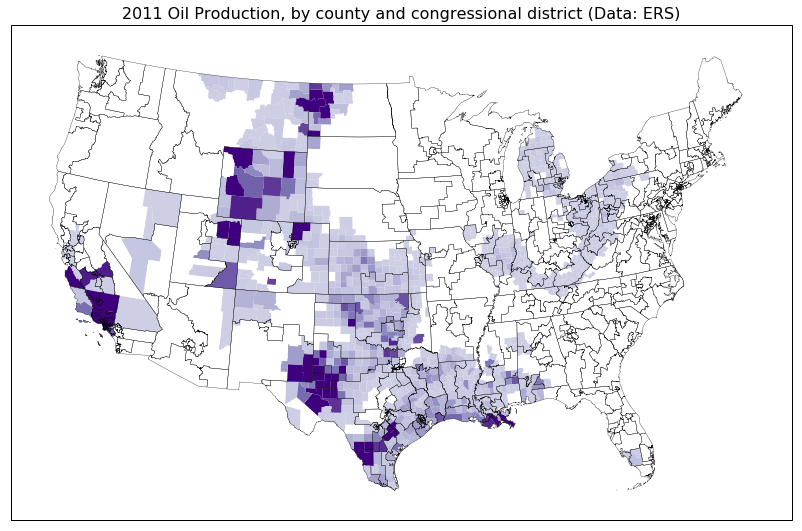

In [14]:
# MAP: 2011 Oil Production by County, with overlaid CDs
# set up the projection
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])
cmap = mpl.cm.get_cmap('Purples')  # colormap
oilmax = 10000000.0

# read from the conus gp
for statefp, countyfp, name, poly in zip(conus['STATEFP'], conus['COUNTYFP'], conus['NAME'], conus.geometry):
    fips = int(statefp)*1000 + int(countyfp)
    rows = og_conus_0017[og_conus_0017['FIPS']==fips]  # select rows on fips  
    if len(rows)==1:   # if there is exactly one record in the oil db...
        oil2011 = rows['oil2011'].iloc[0]
        if oil2011 == 0.0:
            color = 'white'
        else:
            color = cmap(0.3 + oil2011/oilmax)  # tune cmap, darker=higher production
        shape = ShapelyFeature([poly], ccrs.PlateCarree(), facecolor=color)
        ax.add_feature(shape, linewidth=0.0)

# overlay the CD shapefile
for poly in cds115.geometry:
    test2 = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    ax.add_feature(test2, linewidth=0.3, zorder=2)

plt.title('2011 Oil Production, by county and congressional district (Data: ERS)', fontsize=16)

<a href='#toc'>return to top</a>
### 2. Oil Production, by county 2017 (estimated)<a id='ogct17'></a>

The xlsx file loaded above also contains estimated oil production values by county for 2017. This version is identical to the ERS county-level dataset, with the following additional columns:<br>
-- basin_id: For states TX, NM, OK, LA and AR, this column indicates if the county is considered by EIA to be part of the Permian, Eagle Ford, Anadarko or Haynesville basins, or none of the above (as defined by the EIA Drilling Productivity Report). For all other states left blank.<br>
-- oil_del17: Shows the estimated % increase or decrease in oil production from 2011 to 2017 for each county. This increase/decrease is taken from EIA state production trends, except for TX, NM, OK, LA, AR where it is taken from basin-level trends.<br>
-- gas_del17: Shows the estimated % increase or decrease in gas production from 2011 to 2017 for each county.<br>
-- oil2017: Shows estimated oil production for 2017, derived from above.<br>
-- gas2017: Shows estimated gas production for 2017, derived from above.<br>

The general result here is that since 2011 some regions (TX Permian, ND Bakken, etc) have increased production, others have declined somewhat (AK and CA, for example).

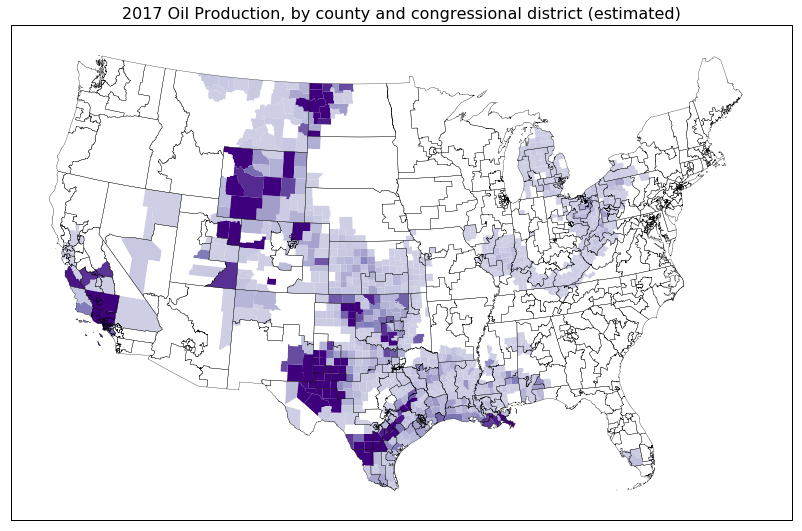

In [15]:
# MAP: 2017 Oil Production by County, with overlaid CDs
# set up the projection
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])
cmap = mpl.cm.get_cmap('Purples')  # colormap
oilmax = 10000000.0

# read from the conus gp
for statefp, countyfp, name, poly in zip(conus['STATEFP'], conus['COUNTYFP'], conus['NAME'], conus.geometry):
    fips = int(statefp)*1000 + int(countyfp)
    rows = og_conus_0017[og_conus_0017['FIPS']==fips]  # select rows on fips
    if len(rows)==1:   # if there is exactly one record in the oil db...
        oil2017 = rows['oil2017'].iloc[0]
        if oil2017 == 0.0:
            color = 'white'
        else:
            color = cmap(0.3 + oil2017/oilmax)  # tune cmap, darker=higher production
        shape = ShapelyFeature([poly], ccrs.PlateCarree(), facecolor=color)
        ax.add_feature(shape, linewidth=0.0)

# overlay the CD shapefile
for poly in cds115.geometry:
    test2 = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    ax.add_feature(test2, linewidth=0.3, zorder=2)

plt.title('2017 Oil Production, by county and congressional district (estimated)', fontsize=16)

<a href='#toc'>return to top</a>
### 3. Oil Production, by CD 2017 (estimated)<a id='ogcd17'></a>

Using shapely to calculate the area intersection between counties and CDs...

In [16]:
# test: overlap between Louisiana LA-02 and county 005
test_la02 = cds115[(cds115['STATEFP']=='22') & (cds115['CD115FP']=='02')].iloc[0]['geometry']
test_la_asc = conus[(conus['STATEFP']=='22') & (conus['COUNTYFP']=='005')].iloc[0]['geometry']

In [17]:
# output areas
test_la02.area, test_la_asc.area, test_la02.intersection(test_la_asc).area

(0.35579376824644104, 0.07345784467599993, 0.024395892808999873)

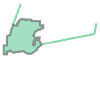

In [18]:
test_la02.intersection(test_la_asc)

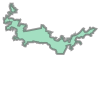

In [19]:
test_la02

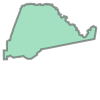

In [20]:
test_la_asc

In [21]:
# read in the CD to CONUS national relationship map from Census
cdco = pd.read_excel('natl_cocd_delim.xlsx', dtype=str)  # don't type to int!
cdco.head()

,State,County,Congressional District
0,01,001,02
1,01,003,01
2,01,005,02
3,01,007,06
4,01,009,04


In [22]:
# we want a list of overlapping counties for each CD, so let's try groupby
grouped = cdco.groupby(['State', 'Congressional District'])

In [23]:
# let's put our lists into a dataframe
pairs = []
labels = ['State', 'CD', 'Counties']
for name, group in grouped:
    counties = grouped.get_group(name)['County'].values
    pairs.append((name[0], name[1], counties))
#    print name[0], name[1], counties
#    print group

cdco_gr = pd.DataFrame.from_records(pairs, columns=labels)

In [24]:
# new grouped dataframe gives us a nice list of counties for each CD
cdco_gr.head(10)

,State,CD,Counties
0,01,01,"[003, 025, 053, 097, 099, 129]"
1,01,02,"[001, 005, 011, 013, 031, 035, 039, 041, 045, ..."
2,01,03,"[015, 017, 019, 027, 029, 081, 087, 101, 111, ..."
3,01,04,"[009, 019, 033, 043, 049, 055, 057, 059, 071, ..."
4,01,05,"[071, 077, 083, 089, 103]"
5,01,06,"[007, 009, 021, 037, 073, 117]"
6,01,07,"[023, 025, 047, 063, 065, 073, 085, 091, 101, ..."
7,04,01,"[001, 005, 007, 009, 011, 013, 015, 017, 019, ..."
8,04,02,"[003, 019]"
9,04,03,"[013, 019, 021, 023, 027]"


Having generated a database of CDs and the counties they overlap, we can then calculate the area overlap for each, and assign a fraction of each county's oil production to the CD.

In [25]:
orows = []
olabels = ['Code', 'State', 'CD', 'Oil_2017', 'Gas_2017']

# for all states
for state in list_states:
    state_oil = state_gas = 0.0

    # for all CDs in state
    list_cds = cds115[cds115['STATEFP']==state]['CD115FP'].values
    if len(list_cds)==1:   # special case of at-large districts, which are NOT in cdco_gr
        # NOTE ALASKA/HAWAII ARE MISSING DATA
        state_oil = og_conus_0017[og_conus_0017['Stabr']==census_state_lookup[state]]['oil2017'].sum()
        state_gas = og_conus_0017[og_conus_0017['Stabr']==census_state_lookup[state]]['gas2017'].sum()
        code = census_state_lookup[state]+'00'
        orows.append((code, state, '00', state_oil, state_gas))
        print "AT LARGE:", state, list_cds[0], state_oil
    else:
        for cd in list_cds:
            code = census_state_lookup[state]+cd
            geom_cd = cds115[(cds115['STATEFP']==state) & (cds115['CD115FP']==cd)].iloc[0]['geometry']
            cnty_breakdown = cdco_gr[(cdco_gr['State']==state) & (cdco_gr['CD']==cd)]
            if len(cnty_breakdown)>0:
                list_linked_cntys = cnty_breakdown['Counties'].iloc[0]
    
                # for each county in list, calculate % area that overlaps with CD
                chksum = 0.0  # checksum of intersection areas = area of CD
                cd_oil2017 = cd_gas2017 = 0.0
                for cnty in list_linked_cntys:
                    select_cnty = conus[(conus['STATEFP']==state) & (conus['COUNTYFP']==cnty)]
                    if len(select_cnty)==1:
                        geom_cnty = select_cnty.iloc[0]['geometry']
                        geom_intc = geom_cd.intersection(geom_cnty)
                        cnty_frac = geom_intc.area / geom_cnty.area  # fraction of county found inside CD
                        chksum += geom_intc.area
        
                        # weight oil/gas production for each county and sum over CD
                        fips = int(state)*1000 + int(cnty)
                        rows = og_conus_0017[og_conus_0017['FIPS']==fips]
                        if len(rows)==1:   # if there is a records in the oil/gas db...
                            oil2017 = rows['oil2017'].iloc[0]
                            gas2017 = rows['gas2017'].iloc[0]
                        else:
                            oil2017 = gas2017 = 0.0
                        cd_oil2017 += cnty_frac * oil2017
                        cd_gas2017 += cnty_frac * gas2017
                    else:
                        print "missing", state, cd, cnty

            state_oil += cd_oil2017
            state_gas += cd_gas2017
            print "  CD=", cd, "chksum=", geom_cd.area / chksum, "cd_oil2017=", cd_oil2017
            orows.append((code, state, cd, cd_oil2017, cd_gas2017))

        print "STATE=", state, "state_oil=", state_oil, "state_gas=", state_gas

cdprod_2017 = pd.DataFrame.from_records(orows, columns=olabels)

  CD= 05 chksum= 1.0 cd_oil2017= 0.0
  CD= 06 chksum= 1.0 cd_oil2017= 0.0
  CD= 02 chksum= 1.0 cd_oil2017= 2742071.8
  CD= 01 chksum= 1.0 cd_oil2017= 3602370.75049
  CD= 04 chksum= 1.0 cd_oil2017= 71267.7708087
  CD= 03 chksum= 1.0 cd_oil2017= 0.0
  CD= 07 chksum= 1.0 cd_oil2017= 438648.358704
STATE= 01 state_oil= 6854358.68 state_gas= 146166632.7
AT LARGE: 02 00 0
  CD= 02 chksum= 1.0 cd_oil2017= 0.0
  CD= 09 chksum= 1.0 cd_oil2017= 0.0
  CD= 05 chksum= 1.0 cd_oil2017= 0.0
  CD= 01 chksum= 1.0 cd_oil2017= 12923.75
  CD= 04 chksum= 1.0 cd_oil2017= 0.0
  CD= 03 chksum= 1.0 cd_oil2017= 0.0
  CD= 06 chksum= 1.0 cd_oil2017= 0.0
  CD= 08 chksum= 1.0 cd_oil2017= 0.0
  CD= 07 chksum= 1.0 cd_oil2017= 0.0
STATE= 04 state_oil= 12923.75 state_gas= 55542.3
  CD= 01 chksum= 1.0 cd_oil2017= 0.0
  CD= 04 chksum= 1.0 cd_oil2017= 3505757.52
  CD= 02 chksum= 1.0 cd_oil2017= 0.0
  CD= 03 chksum= 1.0 cd_oil2017= 0.0
STATE= 05 state_oil= 3505757.52 state_gas= 693142752.31
  CD= 41 chksum= 1.0 cd_oil2017= 0

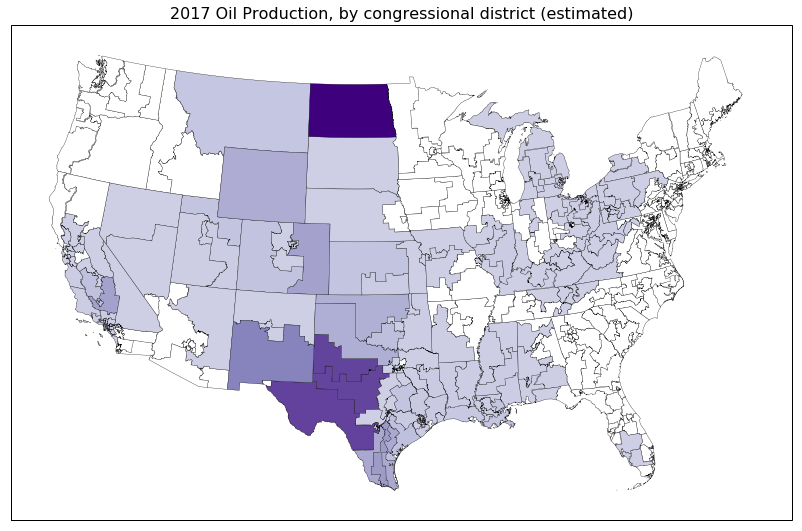

In [55]:
# MAP: 2017 Oil Production by CD
# set up the projection
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])
cmap = mpl.cm.get_cmap('Purples')  # colormap
oilmax = cdprod_2017['Oil_2017'].max()

for state, cd, poly in zip(cds115['STATEFP'], cds115['CD115FP'], cds115.geometry):
    cdint = int(cd)
    stint = int(state)
    if (stint<=56) & (cdint<60):  # exclude non-state entities
        oil_cd = cdprod_2017[(cdprod_2017['State']==state) & (cdprod_2017['CD']==cd)]['Oil_2017'].iloc[0]
        if oil_cd == 0.0:
            color = 'white'
        else:
            color = cmap(0.3 + 0.7*(oil_cd/oilmax))  # tune the cmap, darker=higher production

        test2 = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
        ax.add_feature(test2, linewidth=0.3, zorder=2)
        
plt.title('2017 Oil Production, by congressional district (estimated)', fontsize=16)

Let's sort by production level to see who the top CDs are. One caveat here, is that due to uncertainties in this calculation, we probably can't trust the absolute rankings here, but these do seem to be the top districts in general.

In [30]:
cdprod_2017.sort_values(by=['Oil_2017'], ascending=False).head(20)

,Code,State,CD,Oil_2017,Gas_2017
298,ND00,38,00,3.932259e+08,6.826097e+08
387,TX23,48,23,2.770092e+08,1.930320e+09
374,TX19,48,19,2.742243e+08,2.839143e+08
368,TX11,48,11,2.724452e+08,5.478243e+08
257,NM02,35,02,1.683078e+08,8.196460e+08
386,TX15,48,15,1.102983e+08,3.397273e+08
76,CO04,08,04,9.901227e+07,4.161581e+08
31,CA23,06,23,9.725530e+07,1.000207e+08
365,TX28,48,28,8.433441e+07,1.190879e+09
385,TX34,48,34,8.221109e+07,3.635242e+08


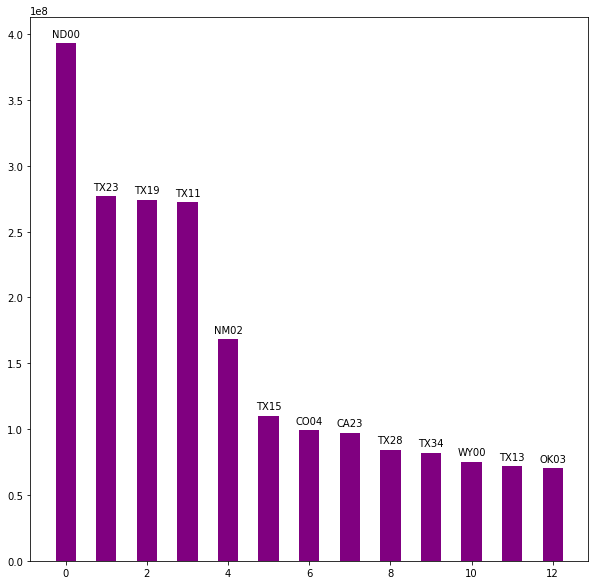

In [31]:
nplot = 13
sortoil = cdprod_2017.sort_values(by=['Oil_2017'], ascending=False).head(nplot)['Oil_2017']
sortcode = cdprod_2017.sort_values(by=['Oil_2017'], ascending=False).head(nplot)['Code']

# TODO: don't forget to add Alaska here!!!
fig, ax = plt.subplots(figsize=(10, 10))
ind = np.arange(nplot)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

offset = 5e6
p1 = plt.bar(ind, sortoil, width, color='purple')
#p2 = plt.bar(ind, sortgas, width, color='orange')
for i in range(len(sortcode)):
    plt.text(ind[i], sortoil.values[i]+offset, str(sortcode.values[i]), ha='center')

In [32]:
# these 14 districts pump around 80% of US onshore oil
[cdprod_2017['Oil_2017'].sum() + 180467000.0,  # adding AK
 (sortoil.sum()+180467000.0) / (cdprod_2017['Oil_2017'].sum()+180467000.0)]

[2780791228.2799997, 0.81140926256961532]

Finally, let's make a different version of the CD map, color-coding by production levels, to highlight the 14 districts.

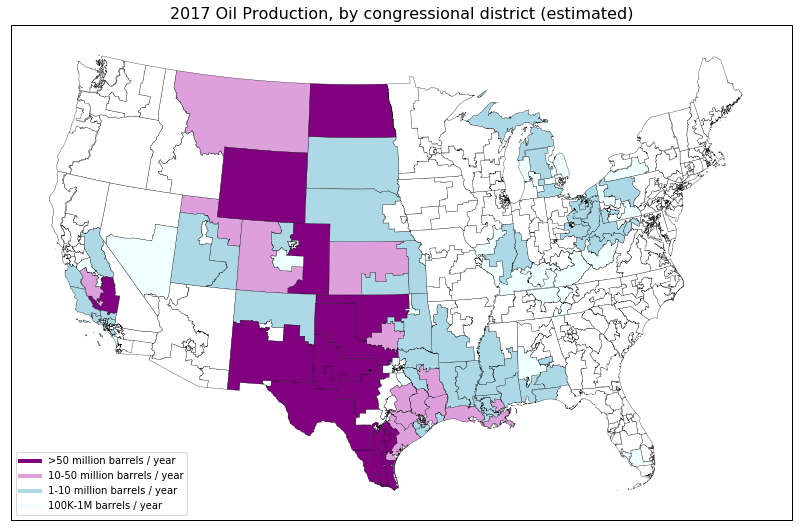

In [33]:
# MAP: 2017 Oil Production by CD (color-coded by production levels)
# set up the projection
fig, ax = plt.subplots(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35))
ax.set_extent([-122,-72,22,50])
cmap = mpl.cm.get_cmap('Purples')  # colormap

#oilmax = cdprod_2017['Oil_2017'].max()
for state, cd, poly in zip(cds115['STATEFP'], cds115['CD115FP'], cds115.geometry):
    cdint = int(cd)
    stint = int(state)
    if (stint<=56) & (cdint<60):  # exclude non-state entities
        #print state, cd
        oil_cd = cdprod_2017[(cdprod_2017['State']==state) & (cdprod_2017['CD']==cd)]['Oil_2017'].iloc[0]
        if oil_cd >= 5e7:
            color = 'purple'
        elif oil_cd >= 1e7:
            color = 'plum'
        elif oil_cd >= 1e6:
            color = 'lightblue'
        elif oil_cd >= 1e5:
            color = 'azure'
        else:
            color = 'white'

        test2 = ShapelyFeature([poly], ccrs.PlateCarree(), edgecolor='black', facecolor=color)
        ax.add_feature(test2, linewidth=0.3, zorder=2)
        
custom_lines = [Line2D([0], [0], color='purple', lw=4),
                Line2D([0], [0], color='plum', lw=4),
                Line2D([0], [0], color='lightblue', lw=4),
                Line2D([0], [0], color='azure', lw=4)]
ax.legend(custom_lines, ['>50 million barrels / year', '10-50 million barrels / year', 
                         '1-10 million barrels / year', '100K-1M barrels / year'], loc='lower left')
plt.title('2017 Oil Production, by congressional district (estimated)', fontsize=16)